Fabio Ceruti

Fabio Martino

Jacopo Biggiogera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import spacy
from nltk.corpus import stopwords
from gensim.models.phrases import Phrases
import pandas as pd
import sys 
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import wordcloud
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from bs4 import BeautifulSoup
import requests
output_stream = sys.stdout

In [3]:
#Importing the dataset
tweets = pd.read_csv('Data_PCLab3_Twitter_Stock_Sentiment.csv')

## Data manipulation and descriptive statistics

In [4]:
#loading spacy model
nlp = spacy.load('en_core_web_sm', disable=['ner', 'textcat']) 

In [5]:
#Before preprocessing:Generating a dictionary of words (useful for visualisation)
words = defaultdict(lambda: 0)
dc = []
for doc in tqdm(tweets['Text'].tolist()):
    d = []
    if type(doc) is str:
        for token in doc.split():
            d.append(token)
            words[token] +=1
        dc.append(d)

100%|██████████| 5791/5791 [00:00<00:00, 150705.56it/s]



Summary Statistics (BEFORE PREPROCESSING):

Number of tweets: 5791
Average words per tweets: 14.009
Number of unique words (types): 17824
Number of tokens: 81125
Top 5 most used words: ['the', 'to', 'a', 'on', 'of']
Average Sentiment: 0.636



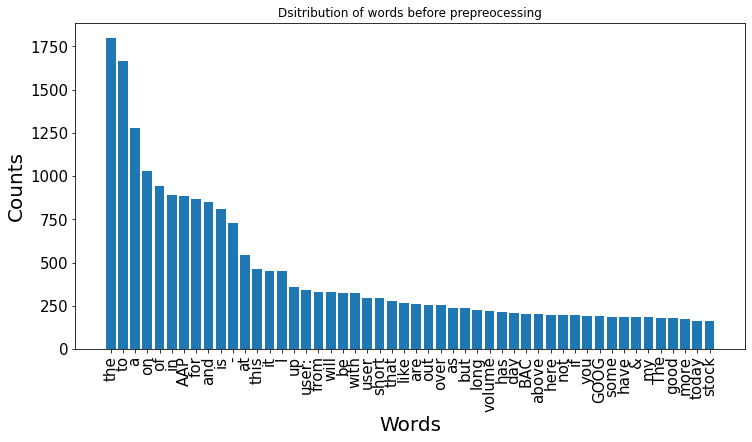

In [6]:
#Statistics before preprocessing:
sort_list_words = [k for k, v in sorted(words.items(), key=lambda item: item[1], reverse = True)]
sort_counts = [v for k, v in sorted(words.items(), key=lambda item: item[1], reverse = True)]
n_docs = tweets.shape[0]
avg_wordsperdoc = sum([len(i) for i in dc])/tweets.shape[0]
n_types = len(words.keys())
n_tokens = sum(words.values())
top5_w = sort_list_words[:5]
print(f'''
Summary Statistics (BEFORE PREPROCESSING):

Number of tweets: {n_docs}
Average words per tweets: {round(avg_wordsperdoc, 3)}
Number of unique words (types): {n_types}
Number of tokens: {n_tokens}
Top 5 most used words: {top5_w}
Average Sentiment: {round(np.mean(tweets['Sentiment']), 3)}
''')

#Plotting the distribution (only first 50 words shown for readibility)

plt.rcParams['figure.figsize'] = [12 , 6]
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.bar(sort_list_words[:50], sort_counts[:50])
plt.xticks(rotation = 90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Dsitribution of words before prepreocessing')
plt.show()

As we can see prior to the preprocessing there is great variability in the words that are present in the list of tweets. It is possible to see that as per the theory the words are distributed according to the Zipf distribution. Indeed, the ones that are most common are words like 'the', 'to' and 'a', also known as stopwords. The latter do not carry much meaning but, by being present in such high numbers, are likely to introduce noise in the data once we move on to modelling. It will thus be important to remove them in the following cleaning steps. Furthermore we can see that tweets are overall short, thus containing very targeted information since they are only 14 words long on average. Finally, we cn see that the average sentiment is slighlty skewed tloards 1 (positive) since its average is 0.63.

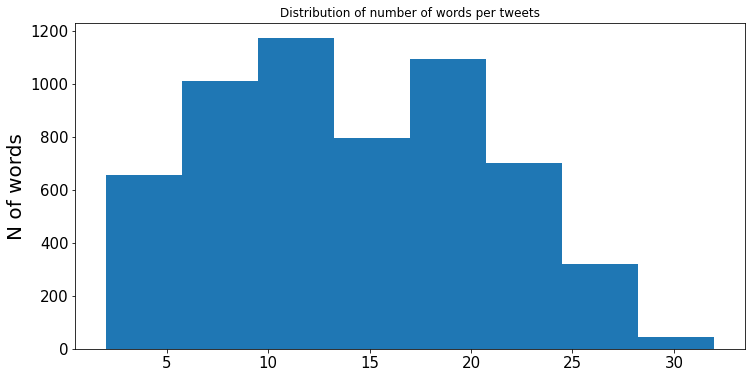

In [6]:
tweets_lengths = [len(i) for i in dc]
plt.hist(tweets_lengths, bins = 8)
plt.title('Distribution of number of words per tweets')
plt.ylabel('N of words')
plt.show()

Form the above distribution we can further note how we are working with text that is overall very short as per the conventions of twitter. Indeed lengths of tweets are not very symmetrically dsitributed but rather slighlty more skewed towards a shorter length.

## Cleaning and visualization

In [7]:
#Scraping ticker names
#Requesting html of page
URL = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')
#Scraping the tickers
tables = soup.find_all("table")
table = tables[0]
tab_data = [[cell.text for cell in row.find_all(["th","td"])]
                        for row in table.find_all("tr")]
#Saving the tickers in a data frame
tickers = pd.DataFrame(tab_data)
tickers = tickers.iloc[:,:2]
#Cleaning text to remove unneded whitespaces
for i in range(tickers.shape[0]):
    tickers.iloc[i,0] = tickers.iloc[i,0].replace('\n','')
tickers.columns = tickers.iloc[0]
tickers.drop(tickers.index[0], inplace = True)
tickers = tickers.replace('APPL', 'APP')

In [8]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [9]:
#Creating a custom set of stopwords that do not include ones that could be potentially meaningful for financial sentiment
fin_stopwords = set(('above', 'against', 'all', 'below', 'down', 'few', 'further', 'just', 'more', 
'most', 'not', 'no', 'off', 'on', 'over', 'out', 'under', 'up', 'very'))
new_stopwords = set(stopwords.words('english')).difference(fin_stopwords)
ticks = set(tickers['Symbol'])

In [34]:
def text_cleaner_lemma(text):
     s = []
     #Extracting lemma
     for token in nlp(text):
          if token.lemma_ not in new_stopwords and token.pos_ not in {'PUNCT'}:
               #setting to lowercase only those words that are not tickers
               if token.lemma_ in ticks:
                    s.append(token.lemma_)
               else:
                    s.append(token.lemma_.lower())
               
     #joining lemmas in a sentence
     sentence = ' '.join(s)

     #removing punctuation
     sentence = re.sub(r'(”|“|-|’|"|#|,|\'|;|\||\.|\\|%|:|/|&|$)*','',sentence)
     sentence = sentence.replace('$', '')
     #removing website format
     sentence = re.sub(r'http\S+','',sentence)

     #removing numbers
     sentence = re.sub(r'[0-9]', '', sentence)

     return sentence


In [35]:
#Testing sentence cleaner
text_cleaner_lemma('0$I love AI & Machine learning applied to Finance...!! ;)')

'i love ai  machine learning apply finance'

In [36]:
#Cleaning the sentences
lem=[]
for j in range(len(tweets.Text)):
    if tweets.Text[j]!='nan':
        text = text_cleaner_lemma(tweets.Text[j])
        lem.append(text)
        output_stream.write('Cleaning %s\r' % j)
        output_stream.flush()
    else:
        lem.append(None)
#saving them in the dataframe
tweets['lemmatized']=lem

In [37]:
#Generating a dictionary of words (useful for visualisation)
wordsc = defaultdict(lambda: 0)
dclean = []
for doc in tqdm(tweets['lemmatized'].tolist()):
    d = []
    if type(doc) is str:
        for token in doc.split():
            d.append(token)
            wordsc[token] +=1
        dclean.append(d)

100%|██████████| 5791/5791 [00:00<00:00, 200712.43it/s]



Summary Statistics (AFTER PREPROCESSING):

Number of tweets: 5791
Average words per tweet: 9.729
Number of unique words (types): 7467
Number of tokens: 56343
Top 5 most used words: ['on', 'AAP', 'i', 'user', 'short'],
Average Sentiment: 0.636



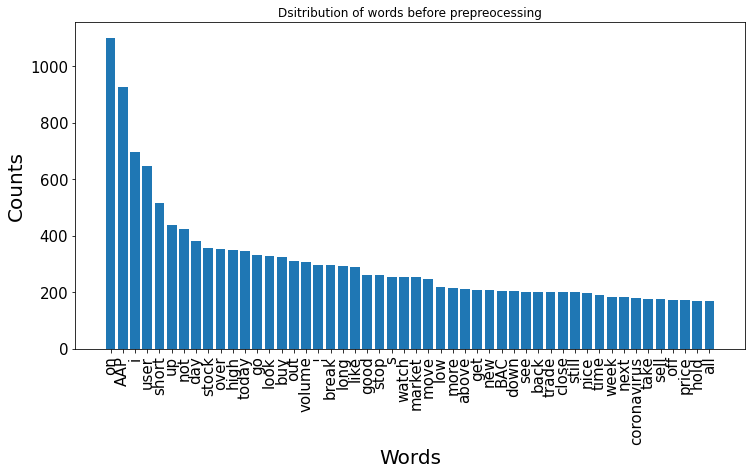

In [38]:
#Statistics after preprocessing:
sort_list_wordsc = [k for k, v in sorted(wordsc.items(), key=lambda item: item[1], reverse = True)]
sort_countsc = [v for k, v in sorted(wordsc.items(), key=lambda item: item[1], reverse = True)]
n_docsc = tweets.shape[0]
avg_wordsperdocc = sum([len(i) for i in dclean])/tweets.shape[0]
n_typesc = len(wordsc.keys())
n_tokensc = sum(wordsc.values())
top5_wc = sort_list_wordsc[:5]
print(f'''
Summary Statistics (AFTER PREPROCESSING):

Number of tweets: {n_docsc}
Average words per tweet: {round(avg_wordsperdocc, 3)}
Number of unique words (types): {n_typesc}
Number of tokens: {n_tokensc}
Top 5 most used words: {top5_wc},
Average Sentiment: {round(np.mean(tweets['Sentiment']), 3)}
''')

#Plotting the distribution (only first 50 words shown for readibility)

plt.rcParams['figure.figsize'] = [12 , 6]
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 20
plt.bar(sort_list_wordsc[:50], sort_countsc[:50])
plt.xticks(rotation = 90)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Dsitribution of words before prepreocessing')
plt.show()

Following the cleaning we can see we have succesfully impacted the quality of the words present in our dataset. Indeed, the number of unique tokens has been cut by more than half (from 17824 before cleaning to 7468 following it), and we can now see that the most common words aere those that actually hold significant financial and sentimentl meaning rather than stopwords. The drop in the average number of words per tweet is a further implication that the cleaning was impactful, while maitianing the overall theoretical sintactical stricture since words are still distributed as a Zipf distribution as per the theory. In addition, as we can see from the histogram below, the lengths of the tweets is still skewed but now even more concentrated towards a shorter length.

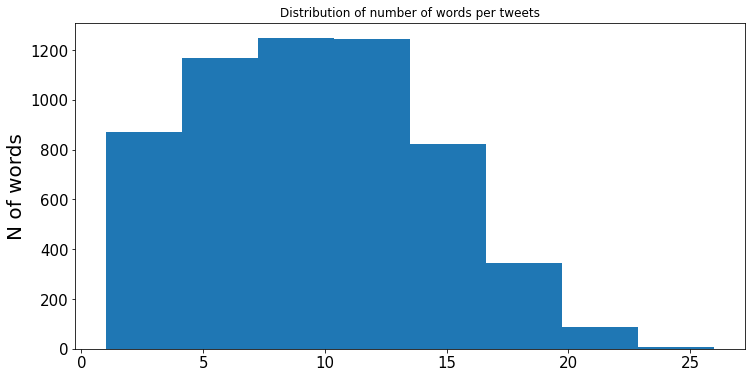

In [16]:
tweets_lengths_clean = [len(i) for i in dclean]
plt.hist(tweets_lengths_clean, bins = 8)
plt.title('Distribution of number of words per tweets')
plt.ylabel('N of words')
plt.show()

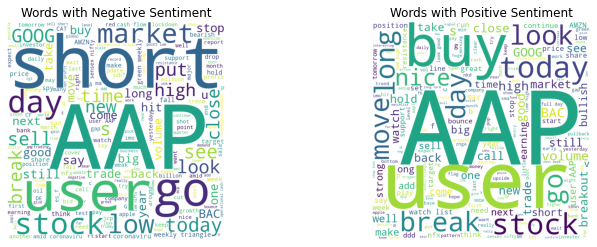

In [17]:
#Plotting wordcloud
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
ax=axs[0]
negative = tweets[tweets['Sentiment'] == 0]['lemmatized'].tolist()
negative = ' '.join(negative)

wordcloud_neg = wordcloud.WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(negative)

ax.imshow(wordcloud_neg)
ax.axis('off')
ax.set_title('Words with Negative Sentiment')
ax=axs[1]
positive = tweets[tweets['Sentiment'] == 1]['lemmatized'].tolist()
positive = ' '.join(positive)

wordcloud_pos = wordcloud.WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(positive)

ax.imshow(wordcloud_pos)
ax.axis("off")
ax.set_title('Words with Positive Sentiment')
plt.show()

As it is possible to see form the above wordclouds we indeed find different patterns of words for tweets categorised with different sentiments. An example is the greater presence of the terms 'short' in the negative sentiment tweets, while a greater presence of 'long' in the positive ones. This might be due to the different level of risk that is associated with each term in the financial world, whereby when you 'short' a stock its more risky and has greater damaging consequences, thus potentially being more frequently linked to negative emotional expressions, wherease going 'long' on a stock is likely to more often being associated to gains, and thus positive emotions. It is interesting to note the widespread presence of the apple ticker in both groups. This is likely due to Apple's widespread predominance in the market that often polarises user's opinions on social media through its varied and controversial choices in terms of business strategy.

## Sentment analysis

In [55]:
np.random.seed(6)
data = tweets.sample(frac=1)
N = len(tweets)
train_size = int(N*0.9)
test_size = int(N*0.1)
train = data[:train_size]
test = data[train_size:]
print(train.shape, test.shape)
target='Sentiment'
y_train = train[target]
y_test = test[target]

(5211, 3) (580, 3)


In [56]:
print(f'Label dist in training set:' + str({k: v/len(y_train) for k, v in Counter(y_train).items()}))
print(f'Label dist in test set:' + str({k: v/len(y_test) for k, v in Counter(y_test).items()}))

Label dist in training set:{1: 0.6350028785261946, 0: 0.3649971214738054}
Label dist in test set:{1: 0.6482758620689655, 0: 0.35172413793103446}


We can indeed see that classes are imbalanced, and thus as we discuss below we will take that into account in our models'evaluations.

In [57]:
#Using TFIDF to vectorise the sentences
vectorizer = TfidfVectorizer(ngram_range=(1,4),
                             lowercase = False,
                             min_df=0.001, 
                             max_df=0.9, 
                             analyzer='word',
                             sublinear_tf=True,
                             #stop_words = 'english',
                            #strip_accents = 'ascii'
                            )

X_tr = vectorizer.fit_transform(train['lemmatized'])
X_ts = vectorizer.transform(test['lemmatized'])
print(X_tr.shape, X_ts.shape)

(5211, 1822) (580, 1822)


In [58]:
from catboost import CatBoostClassifier, Pool
train_dataset = Pool(data=X_tr,
                     label=y_train)

model1 = CatBoostClassifier(iterations=2000,
                           l2_leaf_reg=2,
                           learning_rate=0.01,
                           depth=6,
                           loss_function='Logloss', 
                           verbose=False)
# Fit model
model1.fit(train_dataset)

In [59]:
test_dataset = Pool(data=X_ts,label=y_test)
preds_class = model1.predict(test_dataset)
print(classification_report(y_test, preds_class))
print(f"acuracy: {accuracy_score(y_test, preds_class)}")
print(f"F1_score: {f1_score(y_test, preds_class, average = 'weighted')}")

              precision    recall  f1-score   support

           0       0.78      0.61      0.68       204
           1       0.81      0.90      0.86       376

    accuracy                           0.80       580
   macro avg       0.79      0.76      0.77       580
weighted avg       0.80      0.80      0.80       580

acuracy: 0.8017241379310345
F1_score: 0.7954070522247275


The above results do not reflect the ones we mention in the below table as we unfortunately forgot to set a random seed, and by working parallely we have not be able to replicate the original highest result. (However we can confidently say that it oscillates between 0.8 and 0.82)

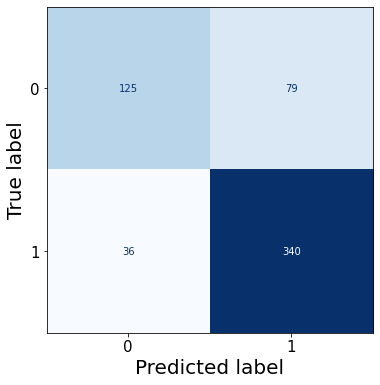

In [60]:
#Plotting the Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, preds_class, labels=model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model1.classes_)
disp.plot(colorbar=False,cmap='Blues')
plt.show()

As we can see from both the confusion matrix and the classification report above our model scores well below chance in all the metrics. Indeed the mistakes it does in class 0 are double the ones it does in class 1 and could be the cause of a performance below 90%. A potential idea for future improvements could be to fine tune the probability decision threshold to account for the greater mistakes in class 0. 

In [37]:
#Importing Model Performances data
models_perf=pd.read_csv('models_performance.csv').iloc[:, :3]

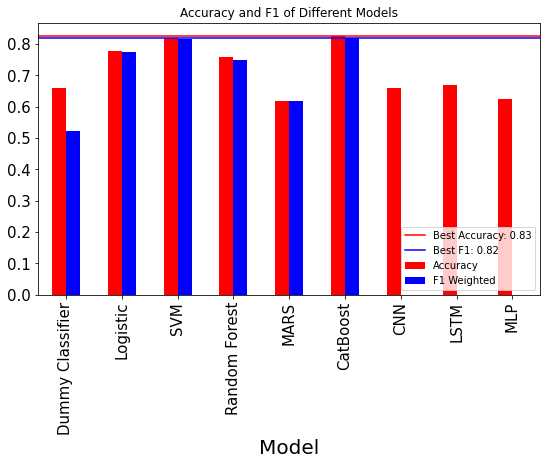

In [38]:
fig, ax =plt.subplots(figsize=(9,5))
ax.axhline(max(models_perf.Accuracy), color='red', label = f'Best Accuracy: {np.round(max(models_perf.Accuracy),2)}')
ax.axhline(max(models_perf['F1 Weighted']), color='blue', label = f"Best F1: {np.round(max(models_perf['F1 Weighted']),2)}")
models_perf.plot.bar(x='Measure', y=['Accuracy', 'F1 Weighted'], ax=ax, color = ['red', 'blue'])
ax.set_xlabel('Model')
ax.set_title('Accuracy and F1 of Different Models')
ax.legend()
plt.show()

For the sake of time in running this notebook we have included only the code for our best performing model. However it is possible to see the comparison of performance of all the models we have explored above. Indeed, the two most performing models are the SVM and the CatBoost, with the latter achieving the overall best performance. Overall, each model went through a process of hyperparameter tuning. In addition, considering the classes imabalances visible in teh code above we decided to not only reort the accuracy metrics, but also the f1-score which is better suited for cases with imablances of this type.

## Sentiment analysis with BERT

In [64]:
#impoorting bert to generate sentiment classification labels
from transformers import pipeline

classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [66]:
#WARNING: LONG RUN 
#Classifying sentiment using BERT
bert_sentiment = []
for t in tweets['Text']:
    res = classifier(t)
    if res[0]['label'] == 'POSITIVE':
        bert_sentiment.append(1)
    else:
        bert_sentiment.append(0)

In [68]:
#Adding it to the DataFrame and testing the performance 
tweets['bert_sentiment'] = bert_sentiment
print(f"Balanced accuracy score of BERT generated labels: {balanced_accuracy_score(tweets['Sentiment'], tweets['bert_sentiment'])}")

Balanced accuracy score of BERT generated labels: 0.6106247447043467


We ran Bert with balanced accuracy due to the above mentioned issue of balanced classes. We can see that performance is not greatly satisfactory.

## FinBERT

In [69]:
#Generating classifier using finBERT
fin_classifier = pipeline("sentiment-analysis",  model = 'ProsusAI/finbert', return_all_scores = True)

Downloading:   0%|          | 0.00/758 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/252 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/pipelines/text_classification.py:90: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  "`return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality", UserWarning


In [70]:
#Generating predictions using finBERT
finbert_sentiment = []
for t in tweets['lemmatized']:
    res = fin_classifier(t)
    vals = [res[0][0]['score'], res[0][1]['score']]
    lab = [res[0][0]['label'], res[0][1]['label']]
    if lab[np.argmax(vals)] == 'positive':
        finbert_sentiment.append(1)
    else:
        finbert_sentiment.append(0)
    

In [73]:
tweets['finbert_sentiment'] = finbert_sentiment
balanced_accuracy_score(tweets['Sentiment'], tweets['finbert_sentiment'])

0.6358519497822981

While indeed performance improved compared to standard Bert it is still not very satisfactory, suggesting further work needed in the model or that maybe it is not built for tweets that are very peculiar as a text form.

## Measuring media attention

In [44]:
positive = defaultdict(int)
negative =defaultdict(int)
tickers_set = set(tickers.Symbol)

#looping through tweets to identify company they refer to
for row in range(tweets.shape[0]):
    for word in tweets.lemmatized[row].split(' '):
        if word in tickers_set and tweets.Sentiment[row]==1:
            positive[word]+=1
            
        if word in tickers_set and tweets.Sentiment[row]==0:
            negative[word]+=1

In [45]:
#Saving data in a DataFrame for easier visualisation
pos = pd.DataFrame(positive.values(), index = positive.keys()).reset_index()
neg = pd.DataFrame(negative.values(), index = negative.keys()).reset_index()
total=pd.merge(pos, neg, how='outer', on='index').rename({'0_x':'positive', '0_y':'negative'}, axis=1)
total=total.fillna(0)
total['total_attention']=total['positive']+total['negative']
total=total.sort_values('total_attention', ascending=False)
attention_scores= total.replace('AAP', 'AAPL')

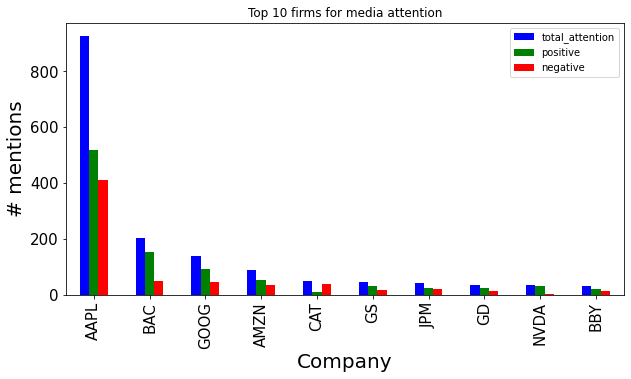

In [46]:
#Visualising the top 10 firms by media attention
fig, ax = plt.subplots(figsize=(10,5))
attention_scores.iloc[:10,:].plot.bar(x='index', y=['total_attention','positive', 'negative'], color=['blue', 'green', 'red'], ax =ax)
ax.set_title('Top 10 firms for media attention')
ax.set_xlabel('Company')
ax.set_ylabel('# mentions')
plt.show()

While looking at the data we noticed that the top ten companies in all forms of attention where always the same and thus decided to plot them in a joint graph. Indeed, it is interesting to notice how most of the terms of attention are motsly large tech companies such as AAPL and Google, which overall receive more positive attenttion than negative. It is very interesting to also add how disproportionately higher attention Apple gets compared to other companies. Considering the hype that the latter's products have received in this decade, generating a lot on engagements on social medias like twitter, it is possible to give more menaning to the result.

In [47]:
#Importing Lab1 data and calculating the returns
df_prices = pd.read_csv("Data_PCLab1_Stock.csv")
l=[]
for i in df_prices.columns[1:-1]:
    initial=df_prices[i].tolist()[0]
    final=df_prices[i].tolist()[-1]
    l.append((final-initial)/initial)

df_rets=pd.DataFrame(l, index =df_prices.columns[1:-1]).rename({0:'Final_return'}, axis=1).reset_index()
df_rets=pd.merge(df_rets, attention_scores, on='index')

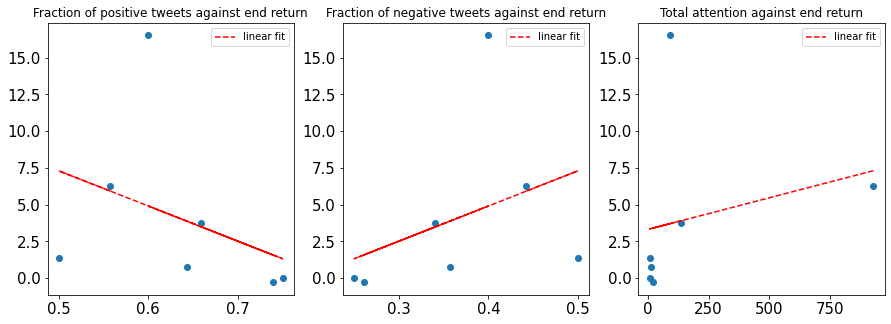

In [48]:
#Visualising relationship between the media attention and returns
fig, axs = plt.subplots(ncols=3, figsize = (15, 5))

ax =axs[0]
pos_proportion=df_rets['positive']/df_rets['total_attention'].to_numpy()
z = np.polyfit(pos_proportion, df_rets['Final_return'], 1)
p = np.poly1d(z)
ax.plot(pos_proportion,p(pos_proportion),"r--", label='linear fit')
ax.scatter(pos_proportion, df_rets['Final_return'])
ax.set_title('Fraction of positive tweets against end return')
ax.legend()

ax =axs[1]
neg_proportion=df_rets['negative']/df_rets['total_attention'].to_numpy()
z = np.polyfit(neg_proportion, df_rets['Final_return'], 1)
p = np.poly1d(z)
ax.plot(neg_proportion,p(neg_proportion),"r--", label='linear fit')
ax.scatter(neg_proportion, df_rets['Final_return'])
ax.set_title('Fraction of negative tweets against end return')
ax.legend()

ax =axs[2]
neg_proportion=df_rets['negative']/df_rets['total_attention'].to_numpy()
z = np.polyfit(df_rets['total_attention'], df_rets['Final_return'], 1)
p = np.poly1d(z)
ax.plot(df_rets['total_attention'],p(df_rets['total_attention']),"r--", label='linear fit')
ax.scatter(df_rets['total_attention'], df_rets['Final_return'])
ax.set_title('Total attention against end return')
ax.legend()
plt.show()

From the above graphs, especially the linear fit, it is possible to notice how there seems indeed to be a relationship between returns and every type of attention. However, this relationship is quite unexpected as a higher proportion of negative tweets is positively correlated with returns, while a higher porportion of positive tweets are negatively correlated with returns. Indeed, we would expect the opposite. Considering the fact that we have a very limited number of samples, before concluding anything as to the relationship between these two variables, we first decided to run the above exploration on a larger dataset. Namely, in the code below, we gathered data from yfinance for all the stocks that are mentioned in the tweets. We then proceeded to plot the above graphs once again and inspected the values and significance of the estimated beta coefficients.

In [51]:
#Scraping of additional stocks from yfinance
import yfinance as yp
data = pd.read_csv('Data_PCLab1_Stock.csv')
scraped_data = yp.download(tickers.Symbol.to_list(), start = data['Date'][0], end = data['Date'].iloc[-1])
scraped_data.head()

[*********************100%***********************]  503 of 503 completed

5 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1326326400, endDate = 1597104000
- OGN: Data doesn't exist for startDate = 1326326400, endDate = 1597104000
- DD: No data found for this date range, symbol may be delisted
- BRK.B: No data found, symbol may be delisted


Adj Close                                                  \
                    A       AAL        AAP       AAPL ABBV        ABC   
Date                                                                    
2012-01-11        NaN       NaN        NaN        NaN  NaN        NaN   
2012-01-12  25.715555  5.703586  67.191956  12.849865  NaN  32.796120   
2012-01-13  25.416233  5.628167  67.013817  12.801685  NaN  31.917957   
2012-01-17  26.021381  5.543320  67.595207  12.950803  NaN  32.340149   
2012-01-18  26.854267  5.694158  69.048767  13.085280  NaN  32.965008   

                                                        ...     Volume  \
                 ABMD        ABT        ACN       ADBE  ...       WYNN   
Date                                                    ...              
2012-01-11        NaN        NaN        NaN        NaN  ...        NaN   
2012-01-12  18.320000  21.490639  44.133892  29.230000  ...  6974000.0   
2012-01-13  17.980000  21.595823  43.569336  28.969999  ...  2641400.0   
2012-01-17  18.049999  21.704914  43.765705  29.350000  ...  3459400.0   
2012-01-18  18.200001  21.568556  44.960281  29.889999  ...  2978200.0   

                                                                               \
                  XEL         XOM       XRAY        XYL        YUM        ZBH   
Date                                                                            
2012-01-11        NaN         NaN        NaN        NaN        NaN        NaN   
2012-01-12  3898800.0  17357200.0   701000.0   709300.0  4792691.0  1604122.0   
2012-01-13  3162300.0  15551600.0   524600.0   886200.0  5074646.0  1077689.0   
2012-01-17  3646100.0  15627900.0   695800.0   465400.0  4190805.0  1495869.0   
2012-01-18  2197000.0  16754200.0  1102500.0  1453700.0  5246852.0  1347961.0   

                                     
                ZBRA       ZION ZTS  
Date                                 
2012-01-11       NaN        NaN NaN  
2012-01-12  190700.0  3832200.0 NaN  
2012-01-13  190300.0  2305200.0 NaN  
2012-01-17   95100.0  2545600.0 NaN  
2012-01-18   86400.0  3065800.0 NaN  

[5 rows x 3018 columns]

In [103]:
full = scraped_data_new.copy(deep=True)
l2=[]
for i in full.columns[1:-1]:
    initial=full[i].tolist()[0]
    final=full[i].tolist()[-1]
    l2.append((final-initial)/initial)

df_rets_full=pd.DataFrame(l2, index =full.columns[1:-1]).rename({0:'Final_return'}, axis=1).reset_index()
df_rets_full=pd.merge(df_rets_full, attention_scores, on='index')
df_rets_full=df_rets_full.dropna()

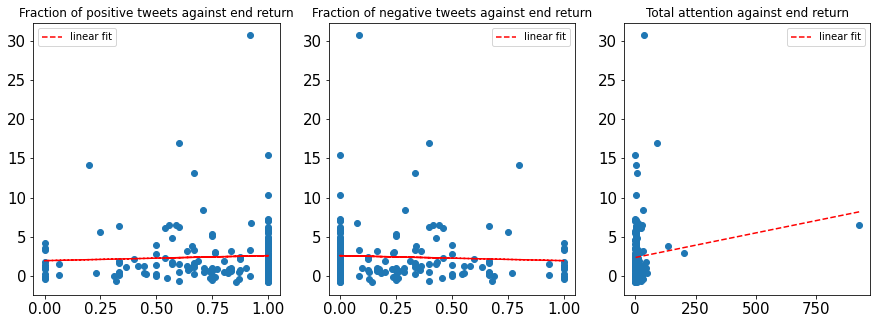

In [104]:
#Visulaising relationship between the media attention and returns
fig, axs = plt.subplots(ncols=3, figsize = (15, 5))

ax =axs[0]
pos_proportion=df_rets_full['positive']/df_rets_full['total_attention'].to_numpy()
z = np.polyfit(pos_proportion, df_rets_full['Final_return'], 1)
p = np.poly1d(z)
ax.plot(pos_proportion,p(pos_proportion),"r--", label='linear fit')
ax.scatter(pos_proportion, df_rets_full['Final_return'])
ax.set_title('Fraction of positive tweets against end return')
ax.legend()

ax =axs[1]
neg_proportion=df_rets_full['negative']/df_rets_full['total_attention'].to_numpy()
z = np.polyfit(neg_proportion, df_rets_full['Final_return'], 1)
p = np.poly1d(z)
ax.plot(neg_proportion,p(neg_proportion),"r--", label='linear fit')
ax.scatter(neg_proportion, df_rets_full['Final_return'])
ax.set_title('Fraction of negative tweets against end return')
ax.legend()

ax =axs[2]
neg_proportion=df_rets_full['negative']/df_rets_full['total_attention'].to_numpy()
z = np.polyfit(df_rets_full['total_attention'], df_rets_full['Final_return'], 1)
p = np.poly1d(z)
ax.plot(df_rets_full['total_attention'],p(df_rets_full['total_attention']),"r--", label='linear fit')
ax.scatter(df_rets_full['total_attention'], df_rets_full['Final_return'])
ax.set_title('Total attention against end return')
ax.legend()
plt.show()

In [108]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

m = sm.OLS(endog=df_rets_full['Final_return'], exog=sm.add_constant(df_rets_full[df_rets_full.columns[2:4]])).fit()

stargazer = Stargazer([m])

HTML(stargazer.render_html())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


As it is possible to see from the graph and the model output above, the relationships have now inverted their valence. Namely, higher proportion of negative tweets is negatively correlated with returns, while a higher proportion of positive tweets or of overall attention is positively correlated with returns. In addition, this is further supported by the beta coefficients that for positive and negative attention are both statistically significant at percent and with a negative and positive sign respectively. This preliminary analysis points at the fact that indeed tweets could potentially be a good factor for returns. However, we can not confidently conclude and further investigations would need to be ran. A good idea would be to run a post double selection lasso whereby we test the marginal importance of this factor after having controlled for its correlation with all the other factors.

## Testing 'descriptiveness on social media' of company as a potential factor

While we analysed media attention we thought that another interesting factor could be what we termed as 'descriptiveness'. It could very well be possible that it is not only a question of attention, nut also of how descriptive and thus impactful are in terms of details the tweets for a reader. For this reason we decided to count the total number of adjectives that describe every company in the tweets. The idea is that the more a company has been described by people on tweets though adjectives (that should convey a company's perception, values and ideas) the more it might have its returns affected. This is because individuals should have a beter idea of how their own perceptions and values align with teh companuy in question.

In [85]:
tot_adjs = defaultdict(int)

for row in range(tweets.shape[0]):
    txt=tweets.loc[row, 'Text']
    pos_tags=[token.pos_ for token in nlp(txt)]
    tot=sum([1 for j in pos_tags if j =='ADJ']) 
    for word in tweets.Text[row].split(' '):
        if word in tickers_set:
            tot_adjs[word]+=tot

adjectives = pd.DataFrame(tot_adjs.values(), index = tot_adjs.keys()).reset_index().rename({0:'Tot_ADJ'}, axis=1)
adjectives = adjectives.replace('AAP', 'AAPL')

In [101]:
df_rets_adj=pd.merge(df_rets_full, adjectives, on='index')
df_rets_adj=df_rets_adj.sort_values('Final_return')
df_rets_adj = df_rets_adj[df_rets_adj['Tot_ADJ'].isna()==False]
df_rets_adj = df_rets_adj[df_rets_adj['Final_return'].isna()==False]

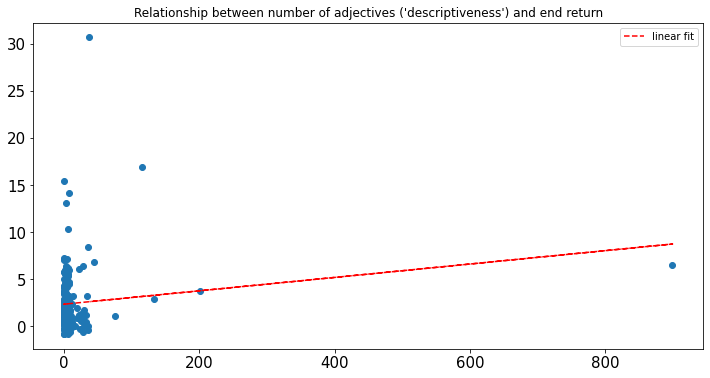

In [102]:
pos_proportion=np.array(df_rets_adj['Tot_ADJ'])#/sum(df_rets['Tot_ADJ'])#.to_numpy()
z = np.polyfit(pos_proportion, df_rets_adj['Final_return'], 1)
p = np.poly1d(z)
plt.plot(pos_proportion,p(pos_proportion),"r--", label='linear fit')
plt.scatter(pos_proportion, df_rets_adj['Final_return'])
plt.title("Relationship between number of adjectives ('descriptiveness') and end return")
plt.legend()
plt.show()

In [100]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

m = sm.OLS(endog=df_rets_adj['Final_return'], exog=sm.add_constant(df_rets_adj[df_rets_adj.columns[5]])).fit()

stargazer = Stargazer([m])

HTML(stargazer.render_html())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


The above results highlight how there is a positive correlation between descriptiveness and returns. However, if we inspect the beta coefficient, while we see that it is significant, we also gather that its magnitude is very limited. Thus while in theory results point it at potentially being a good factor, to avoid the proliferation of the 'factor zoo' it is crucuially important to run further checks on the marginal importance of this factor before declaring it as an appropriate one.